In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset from CSV files
def load_data():
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")

    # Assuming last column is the target variable
    X_train = train_df.iloc[:, :-1].values
    y_train = train_df.iloc[:, -1].values
    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values

    return X_train, y_train, X_test, y_test

# Preprocess data
X_train, y_train, X_test, y_test = load_data()

# Convert categorical labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Normalize feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fix issue: reshape data to have a meaningful timesteps value
timesteps = 10  # Choose a reasonable number of timesteps
features = X_train.shape[1] // timesteps  # Ensure features are properly divided

X_train = X_train[:, :timesteps * features].reshape(X_train.shape[0], timesteps, features)
X_test = X_test[:, :timesteps * features].reshape(X_test.shape[0], timesteps, features)


In [12]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

def build_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),  # تقليل الـ overfitting

        Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),  # زيادة العشوائية وتقليل التخصيص الزائد

        LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),  # Dropout قوي قبل الإخراج

        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(X_train.shape[1:], y_train.shape[1])
model.summary()

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.2f}')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 8, 64)               │          10,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 2, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,246 (352.52 KB)

 Trainable params: 89,862 (351.02 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4228 - loss: 1.4892 - val_accuracy: 0.8670 - val_loss: 0.5081
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8731 - loss: 0.5512 - val_accuracy: 0.9152 - val_loss: 0.4257
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9229 - loss: 0.4128 - val_accuracy: 0.9474 - val_loss: 0.3255
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9388 - loss: 0.3564 - val_accuracy: 0.9243 - val_loss: 0.3843
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9568 - loss: 0.3058 - val_accuracy: 0.9382 - val_loss: 0.3292
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9604 - loss: 0.2743 - val_accuracy: 0.9460 - val_loss: 0.2979
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9674 - loss: 0.2494 - val_accuracy: 0.9389 - val_loss: 0.3209
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9696 - loss: 0.2386 - val_accuracy

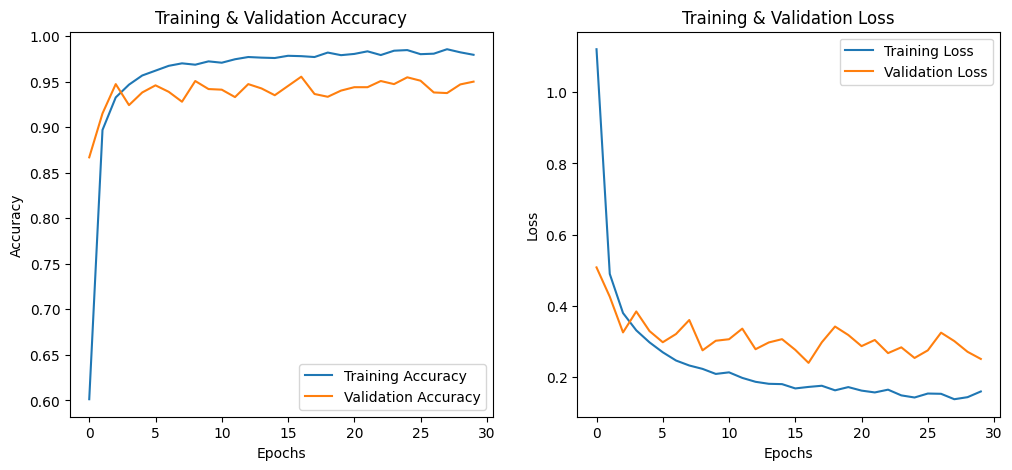

In [13]:
import matplotlib.pyplot as plt

# رسم الدقة
plt.figure(figsize=(12, 5))

# دقة التدريب والتحقق
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# الخسارة (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

In [14]:
model.save("model.h5")

In [15]:
from tensorflow.keras.models import load_model

model = load_model("model.h5")  # استبدل بالمسار الفعلي للموديل

In [19]:
import numpy as np

# عدد الخطوات الزمنية والميزات (استبدل بالقيم الصحيحة من تدريب الموديل)
time_steps = 50    # عدد الخطوات الزمنية
num_features = 56  # هذا هو العدد الصحيح للميزات بناءً على الخطأ

# إنشاء بيانات تجريبية بنفس الأبعاد المطلوبة
new_data = np.random.rand(time_steps, num_features)  # بيانات عشوائية لتتناسب مع النموذج

# تعديل الأبعاد لتتوافق مع مدخلات الموديل
new_data = new_data.reshape((1, time_steps, num_features))

# طباعة شكل البيانات للتأكد من تطابقها مع توقعات الموديل
print("شكل البيانات الجديدة:", new_data.shape)

# تمرير البيانات إلى الموديل
predictions = model.predict(new_data)
predicted_class = np.argmax(predictions, axis=1)  # استخراج الفئة المتوقعة

print(f"Predicted Class: {predicted_class}")


شكل البيانات الجديدة: (1, 50, 56)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
Predicted Class: [3]


In [20]:
class_labels = ["Walking", "Running", "Jumping", "Sitting", "Standing", "Lying"]
print(f"Predicted Activity: {class_labels[predicted_class[0]]}")

Predicted Activity: Sitting
